In [1]:
import os, cv2, torch, numpy as np, matplotlib.pyplot as plt, gc, pandas as pd
from Semi_supervised import MultiScaleUNet as MSU
from skimage.measure import regionprops_table
from tqdm import tqdm

### Set things up (Please make sure these are all correct)

In [2]:
torch.cuda.empty_cache()

In [3]:
# Set your device. CUDA GPU will boost speed of prediction to the next level. 
# If don't have it, default to use CPU that every computer has
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The names of model you want to load to predict the mask
model_path = "best_student_v2.pth"

# The directory of images you would like to measure the sizes of organoids
img_dir = "test_images/"

# Number of predictions you would like to visualize (sanity check on model performance)
visualize_n = 10

# Resize your image to this size
# The model is trained with images of size (512, 512) so better set this the same as the size of images used to train the model
img_size = (512,512)

# The model basically predicts the probabilities of whether a given pixel belongs to an organoid or not
# Pixels with prob. exceeding thresh will be interpreted as organoid present. Otherwise, it is background (no organoid present)
thresh = 0.5

# Optional: If none, organoid sizes will not be saved but printed in this notebook.
# If set, organoid sizes will be saved in a .csv in the specified directory with given name
# e.g. "your_directory/your_file_name.csv"
# save_name = None
save_name = "Test_organoid_data.csv"

In [4]:
model = MSU()
model.load_state_dict(torch.load(model_path, map_location=device, weights_only = True))
model.to(device).eval()

MultiScaleUNet(
  (e1): MultiScaleBlock(
    (c1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (c3): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c5): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (c7): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (fuse): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (e2): MultiScaleBlock(
    (c1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (c7): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (fuse): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (e3): MultiScaleBlock(
    (c1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c5): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 

In [5]:
def fill_holes(mask):
    h, w = mask.shape
    
    # 1) pad mask by one pixel so we can flood-fill from the border
    padded = np.zeros((h+2, w+2), dtype=np.uint8)
    padded[1:-1,1:-1] = mask
    
    # 2) flood-fill the background (label “0”) from (0,0)
    cv2.floodFill(padded, None, (0,0), 255)
    
    # 3) find the holes: wherever padded==0 (inside pockets)  
    holes = (padded[1:-1,1:-1] == 0).astype(np.uint8)
    
    # 4) fill them in the original mask  
    filled = mask | holes

    return filled

def preprocess(img_bgr, img_size):

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, img_size)
    tensor = torch.from_numpy(img_rgb.astype(np.float32)/255.0).permute(2,0,1)

    return tensor.unsqueeze(0).to(device)

**Note: At this time, the program is printing or saving the largest area (largest organoid) detected in the image.**

In [6]:
def predict_visualize(img_dir, img_size, thresh = 0.5, visualize_n = 5, save_name = None):
    to_visualize = list()
    organoid_size = list()
    img_names = sorted(os.listdir(img_dir))
    
    for fname in tqdm(img_names, desc="Predicting"):
        img_path  = os.path.join(img_dir,  fname)
        img  = cv2.imread(img_path)
        
        inp = preprocess(img, img_size)
        with torch.no_grad():
            logit = model(inp)
            prob  = torch.sigmoid(logit)
            pred  = (prob > thresh).cpu().numpy()[0,0].astype(np.uint8)
    
        pred = fill_holes(pred)

        data = pd.DataFrame(regionprops_table(pred, properties = ['area']))

        if save_name:
            organoid_size.append(data['area'].max())
        else:
            print(f"Organoid size: {data['area'].max()}")

        del data
        gc.collect()

        if len(to_visualize) < visualize_n:
            to_visualize.append((img, pred))
    
    if save_name:
        all_data = pd.DataFrame({"Image names": img_names, "Largest organoid sizes (pixels)": organoid_size})
        all_data.to_csv(save_name, index = False)
        del all_data
        gc.collect()
    
    fig, axes = plt.subplots(visualize_n, 2, figsize=(6, 4*visualize_n))
    for i, (img, pr) in enumerate(to_visualize):
    
        axes[i,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i,0].set_title("Image")
        axes[i,0].axis("off")
    
        axes[i,1].imshow(pr, cmap="gray")
        axes[i,1].set_title("Pred Mask")
        axes[i,1].axis("off")
    
    plt.tight_layout()
    plt.show()

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


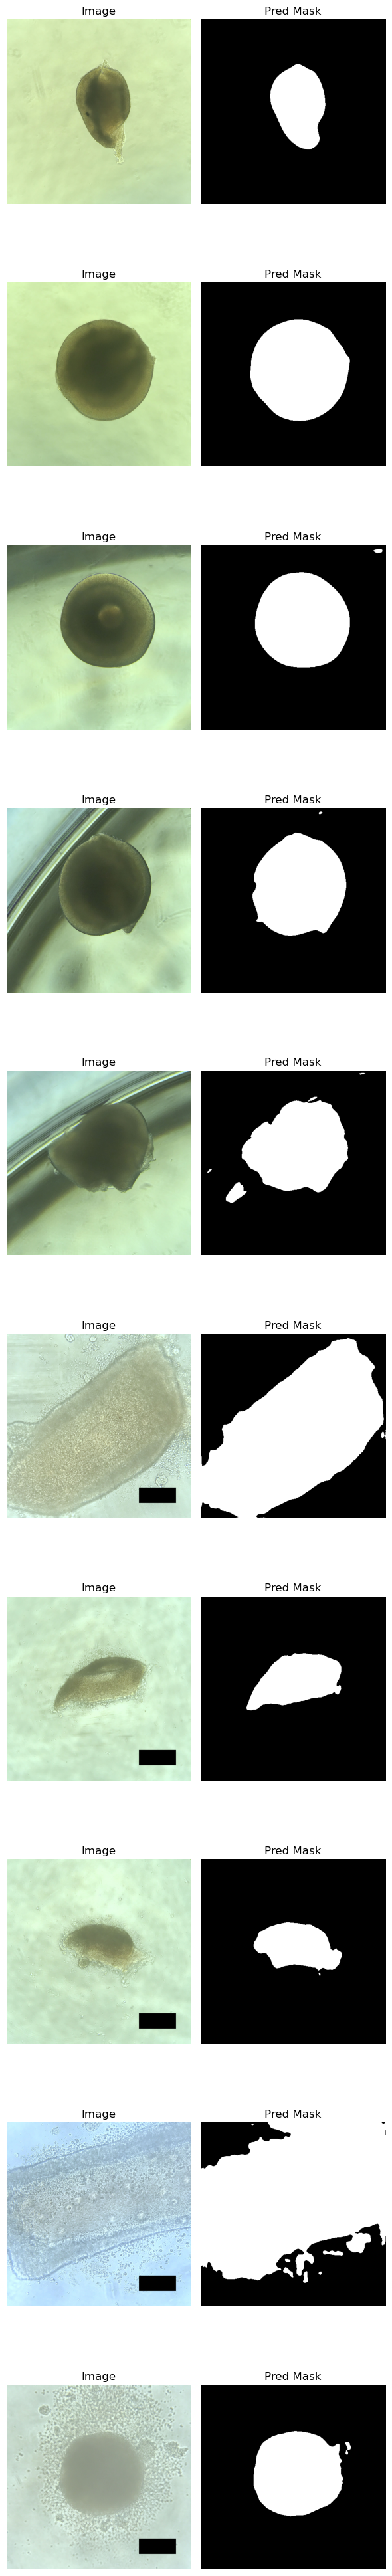

In [7]:
predict_visualize(img_dir, img_size, thresh, visualize_n, save_name = save_name)